# Detecting Planes from Satellite Images
- 32,000 Images
- 200x200 Size
- Filename Format: {label} _ {scene id} _ {longitude} _ {latitude}.png
- label: 1 = plane, 0 = no-plane

# First Attempt Record
Initally, I attempted to modify the example cat vs. dog training code to fit this dataset.
- I ran through a One Block, Two Block, and VGG16 Model but never got over .7480 accuracy. It was also incapable of prediction.
- I tried to add a Dropout layer as well
- I then plotted my images and found that there was some error with how they were being read.
- This caused me to switch from the image_dataset_from_directory function to a custom pipeline following the [Tensorflow Guide](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control).

This immediately changed the results and was getting around .95 accuracy.

In [ ]:
# Inital Dataset Creation
# dir_names = ['no_plane', 'plane']
# train_data = image_dataset_from_directory(out_dir + 'train/', labels='inferred', label_mode='binary', class_names=dir_names, image_size=(200, 200), batch_size=64)
# test_data = image_dataset_from_directory(out_dir + 'test/', labels='inferred', label_mode='binary', class_names=dir_names, image_size=(200, 200), batch_size=64)

In [ ]:
# Initial One Block Model Attempt
# def define_final_model():
# 	model = Sequential()
# 	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
# 	model.add(MaxPooling2D((2, 2)))
# 	model.add(Flatten())
# 	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# 	model.add(Dense(1, activation='sigmoid'))
# 	# compile model
# 	opt = SGD(learning_rate=0.001, momentum=0.9)
# 	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# 	return model

In [ ]:
# Dropout Attempt
# def dropout_model():
#     model = Sequential([
#         # Rescale images to [0, 1] range
#         Rescaling(1./255, input_shape=(200, 200, 3)),
#         Conv2D(16, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
#         Conv2D(32, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
#         Conv2D(64, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
#         Dropout(0.2),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dense(num_classes)
#     ])

#     # compile model
#     model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#     return model

# Setup

In [240]:
from matplotlib import pyplot
from os import makedirs, listdir, path
from shutil import copyfile
from matplotlib import pyplot
import tensorflow as tf
from keras.saving import load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Rescaling, Dense, Flatten, Dropout
import numpy as np
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
!export NVIDIA_DIR=$(dirname $(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)")))
!export LD_LIBRARY_PATH=$(echo ${NVIDIA_DIR}/*/lib/ | sed -r 's/\s+/:/g')${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


2024-04-24 21:06:58.873370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 21:06:58.873459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 21:06:58.873482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 21:06:59.120282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 21:06:59.120334: I external/local_xla/xla/stream_executor

# Create Train/Test Directories

In [198]:
# Set Paths
input_dir = 'data/plane_sat_cv/planesnet/planesnet/'
out_dir = 'data/plane_sat_cv/split_data/'

# Create subdirs
def create_dirs():
    labeldirs = ['plane/', 'no_plane/']
    for labldir in labeldirs:
        newdir = out_dir + labldir
        makedirs(newdir, exist_ok=True)

In [199]:
create_dirs()

In [200]:
# copy images into subdirectories
for file in listdir(input_dir):
    src = input_dir + '/' + file

    if file.startswith('0'):
        dst = out_dir + 'no_plane/' + file
        copyfile(src, dst)
    elif file.startswith('1'):
        dst = out_dir + 'plane/' + file
        copyfile(src, dst)

# Define Diagnostics Plots

In [109]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.show()
	# save plot to file
	# filename = sys.argv[0].split('/')[-1]
	# pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# Create Image Dataset from Pipeline

## Get List of Images

In [241]:
import pathlib
# Set data directory
data_dir = pathlib.Path(out_dir).with_suffix('')
# Find image count
image_count = len(list(data_dir.glob('*/*.png')))
image_count

32000

In [242]:
# Get images into a list
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [243]:
# Output sample to check if everything is correct
for f in list_ds.take(5):
  print(f.numpy())

b'data/plane_sat_cv/split_data/no_plane/0__20160221_180212_0c53__-117.81418717850399_33.669895850336545.png'
b'data/plane_sat_cv/split_data/no_plane/0__20160628_230903_0c13__-117.7079474138907_34.03527327087311.png'
b'data/plane_sat_cv/split_data/no_plane/0__20170728_174522_1001__-117.151445350302_32.70053358442067.png'
b'data/plane_sat_cv/split_data/plane/1__20170121_175133_0e14__-118.402688862_33.941706823.png'
b'data/plane_sat_cv/split_data/no_plane/0__20170627_174937_1015__-118.40247174556953_33.94206419723604.png'


2024-04-25 21:54:45.741770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [286]:
# Find class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'final_model.keras']))
num_classes = len(class_names)
print(class_names, num_classes)

['no_plane' 'plane'] 2


## Split into Training/Validation Sets

In [245]:
# Split into training/validation sets
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [246]:
# Print set lengths
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

25600
6400


## Convert file path to (img, label) pair

In [247]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [200, 200])

def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [248]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [254]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (200, 200, 3)
Label:  0


2024-04-25 21:55:11.431903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Cache, Shuffle, and Batch (Final Sets Defined Here)

In [257]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(64)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# Plot Images

2024-04-25 21:56:30.105250: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


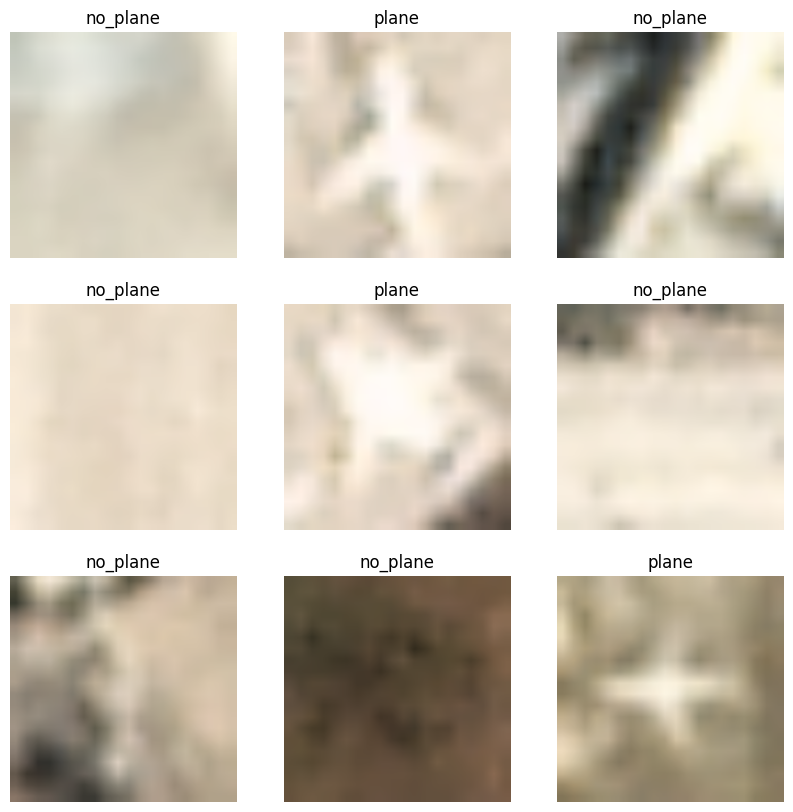

In [262]:
image_batch, label_batch = next(iter(train_ds))

pyplot.figure(figsize=(10, 10))
for i in range(9):
  ax = pyplot.subplot(3, 3, i + 1)
  pyplot.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  pyplot.title(class_names[label])
  pyplot.axis("off")

# Develop Model
This was initally run without Dropout, but it was added to combat some overfitting.

In [268]:
def init_model():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255, input_shape=(200, 200, 3)),
        Conv2D(16, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes)
    ])

    # compile model
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

## Fit and Test

In [269]:
# Declare model
model = init_model()

# Fit model, did not use steps_per_epoch or validation_steps as we are using a tf.data.Dataset object
history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose='auto')

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.7434 - loss: 0.5828 - val_accuracy: 0.8592 - val_loss: 0.3069
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8874 - loss: 0.2879 - val_accuracy: 0.8755 - val_loss: 0.2908
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9055 - loss: 0.2493 - val_accuracy: 0.9237 - val_loss: 0.2099
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9234 - loss: 0.2083 - val_accuracy: 0.9289 - val_loss: 0.1939
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9287 - loss: 0.1908 - val_accuracy: 0.9250 - val_loss: 0.2049
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9373 - loss: 0.1731 - val_accuracy: 0.9425 - val_loss: 0.1604
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9423 - loss: 0.1602 - val_accuracy: 0.9373 - val_loss: 0.1772
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9454 - loss: 0.1538 - va

100/100 - 2s - 16ms/step - accuracy: 0.9242 - loss: 0.1867
> 92.422


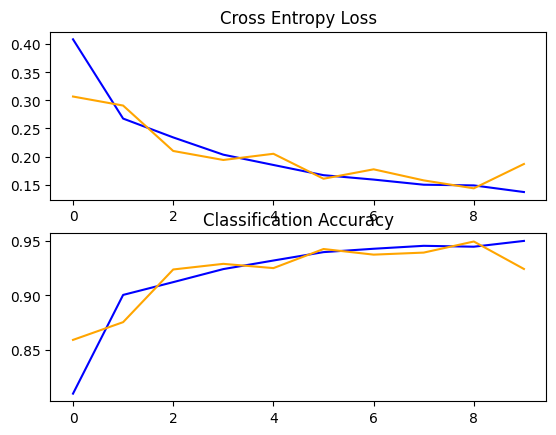

In [272]:
# Evaluate Model
_, acc = model.evaluate(val_ds, steps=None, verbose=2)
print('> %.3f' % (acc * 100.0))

# Learning Curves
summarize_diagnostics(history)

# Prepare Final Dataset

In [273]:
# Create Total Dataset for Final Model
final_ds = list_ds
print(tf.data.experimental.cardinality(final_ds).numpy())
# Convert to (img, label) pair
final_ds = final_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# Configure for Performance
final_ds = configure_for_performance(final_ds)

32000


# Fit and Save Final Model

In [274]:
# Fit model
history = model.fit(final_ds, epochs=9, verbose='auto')

# Evaluate Model
_, acc = model.evaluate(final_ds, steps=None, verbose=2)
print('> %.3f' % (acc * 100.0))

Epoch 1/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 151ms/step - accuracy: 0.9448 - loss: 0.1462
Epoch 2/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9492 - loss: 0.1379
Epoch 3/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9465 - loss: 0.1380
Epoch 4/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9528 - loss: 0.1261
Epoch 5/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9530 - loss: 0.1293
Epoch 6/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9562 - loss: 0.1194
Epoch 7/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9548 - loss: 0.1167
Epoch 8/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9535 - loss: 0.1225
Epoch 9/9
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9581 - loss: 0.1109
500/500 - 7s - 14ms/step - accuracy: 0.9667 - loss: 0.0921
> 96.666


In [276]:
# Save Model
model.save(out_dir + 'final_model.keras')

# Make Prediction

In [287]:
# load an image and predict the class
def predict_class(file_path):
    model = load_model(out_dir + 'final_model.keras')
    
    img = tf.keras.utils.load_img(
        file_path, target_size=(200, 200)
    )
    img_array = tf.keras.utils.img_to_array(img)
    # Create a batch
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [282]:
# Get Image Lists
plane_list = list(data_dir.glob('plane/*'))
no_plane_list = list(data_dir.glob('no_plane/*'))

# Get One Plane Image
plane_path = plane_list[156]
# Get One No Plane Image
no_plane_path = no_plane_list[25]

predict_class(plane_path)
predict_class(no_plane_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
This image most likely belongs to plane with a 96.56 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
This image most likely belongs to no_plane with a 99.98 percent confidence.
